In [1]:
import causalimpact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2024-04-22 15:12:29.436445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the random seed for reproducibility
np.random.seed(42)

# Parameters
n_points = 200  # total number of points
change_point = int(0.7 * n_points)  # point of intervention
slope_pre = 0.5  # slope before intervention
slope_post = 0.5  # slope after intervention
intercept_pre = 5  # intercept before intervention
jump_at_intervention = 5  # sudden jump at the intervention point
noise_level = 2.0  # noise level in the data

# Seasonal parameters
seasonality_period = 12  # typical monthly seasonality
seasonal_amplitude = 3  # amplitude of the seasonal component

# Time periods
time = np.arange(n_points)

# Generating the seasonal component
seasonal_component = seasonal_amplitude * np.sin(2 * np.pi * time / seasonality_period)

# Generating the data
data_pre = (slope_pre * time[:change_point] + intercept_pre + seasonal_component[:change_point] +
            np.random.normal(scale=noise_level, size=change_point))
data_post = (slope_post * time[change_point:] + intercept_pre + jump_at_intervention + 
             seasonal_component[change_point:] + np.random.normal(scale=noise_level, size=n_points - change_point))

# Concatenating the pre and post intervention data
data = np.concatenate([data_pre, data_post])

# Generating the control data without the intervention jump
control_data_pre = slope_pre * time[:change_point] + intercept_pre + seasonal_component[:change_point] + np.random.normal(scale=noise_level, size=change_point)
control_data_post = slope_post * time[change_point:] + intercept_pre + seasonal_component[change_point:] + np.random.normal(scale=noise_level, size=n_points - change_point)

# Concatenating the pre and post control data
control_data = np.concatenate([control_data_pre, control_data_post])

# Creating a pandas DataFrame
ts_data = pd.DataFrame(data, columns=['Value'])
ts_data['Time'] = pd.date_range(start='2021-01-01', periods=n_points, freq='D')
ts_data['Control_Value'] = control_data / 2

ts_data.head(), ts_data.tail(), change_point

(       Value       Time  Control_Value
 0   5.993428 2021-01-01       2.857787
 1   6.723471 2021-01-02       4.060785
 2   9.893453 2021-01-03       5.382089
 3  12.546060 2021-01-04       5.803802
 4   9.129769 2021-01-05       3.421369,
           Value       Time  Control_Value
 195  111.270635 2021-07-15      52.280824
 196  108.830361 2021-07-16      51.085904
 197  110.307450 2021-07-17      53.853872
 198  109.116417 2021-07-18      51.885460
 199  105.714059 2021-07-19      52.737816,
 140)

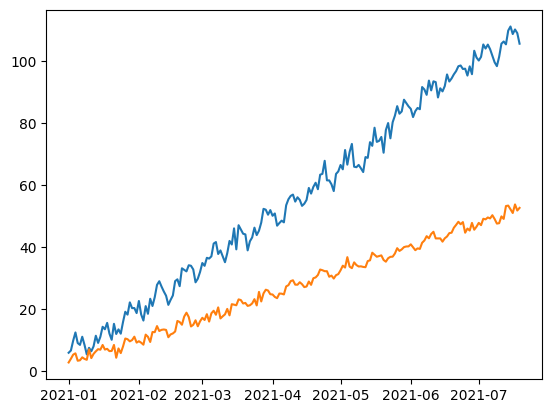

In [3]:
plt.plot(ts_data["Time"], ts_data["Value"])
plt.plot(ts_data["Time"], ts_data["Control_Value"])
plt.show()

In [4]:
df = ts_data.rename(columns={"Value": "y", "Control_Value": "X"}).set_index("Time")

In [5]:
%%time
c = causalimpact.fit_causalimpact(
    df,
    pre_period=["20210101", "20210521"],
    post_period=["20210522", "20210719"],
    inference_options=causalimpact.InferenceOptions(num_results=10000)
)

I0000 00:00:1713790616.499982       1 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-22 14:56:56.505821: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


CPU times: user 12.1 s, sys: 1.28 s, total: 13.4 s
Wall time: 9.6 s


In [6]:
causalimpact.plot(c)

alt.FacetChart(...)

In [7]:
print(causalimpact.summary(c, output_format='summary'))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    95.2               5614.4
Prediction (s.d.)         89.6 (1.97)        5285.7 (116.07)
95% CI                    [85.6, 93.5]       [5051.4, 5514.1]

Absolute effect (s.d.)    5.6 (1.97)         328.7 (116.07)
95% CI                    [1.7, 9.5]         [100.3, 563.0]

Relative effect (s.d.)    6.3% (2.3%)        6.3% (2.0%)
95% CI                    [1.8%, 11.1%]      [1.8%, 11.1%]

Posterior tail-area probability p: 0.002
Posterior prob. of a causal effect: 99.76%

For more details run the command: summary(impact, output_format="report")


/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


In [9]:
print(causalimpact.summary(c, output_format='summary'))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    95.2               5614.4
Prediction (s.d.)         89.7 (1.95)        5290.2 (115.17)
95% CI                    [85.8, 93.4]       [5063.0, 5513.5]

Absolute effect (s.d.)    5.5 (1.95)         324.2 (115.17)
95% CI                    [1.7, 9.3]         [100.9, 551.4]

Relative effect (s.d.)    6.2% (2.3%)        6.2% (2.0%)
95% CI                    [1.8%, 10.9%]      [1.8%, 10.9%]

Posterior tail-area probability p: 0.002
Posterior prob. of a causal effect: 99.75%

For more details run the command: summary(impact, output_format="report")


/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


In [11]:
%%time
c = causalimpact.CausalImpact(
    df,
    pre_period=["20210101", "20210521"],
    post_period=["20210522", "20210719"],
    model_args={"fit_method": "hmc"}
)

/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/causalimpact/data.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 2min 5s, sys: 3.94 s, total: 2min 9s
Wall time: 2min 7s


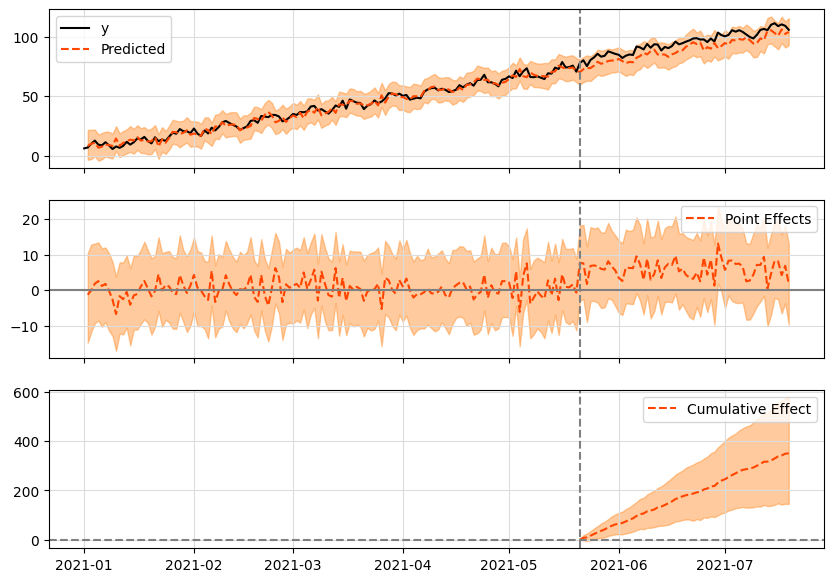

In [12]:
c.plot()

In [13]:
print(c.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    95.16              5614.36
Prediction (s.d.)         89.22 (1.8)        5263.88 (106.47)
95% CI                    [85.7, 92.77]      [5056.03, 5473.38]

Absolute effect (s.d.)    5.94 (1.8)         350.49 (106.47)
95% CI                    [2.39, 9.46]       [140.98, 558.33]

Relative effect (s.d.)    6.66% (2.02%)      6.66% (2.02%)
95% CI                    [2.68%, 10.61%]    [2.68%, 10.61%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [7]:
print(c.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    95.16              5614.36
Prediction (s.d.)         89.23 (3.48)       5264.64 (205.15)
95% CI                    [82.36, 95.99]     [4859.22, 5663.4]

Absolute effect (s.d.)    5.93 (3.48)        349.72 (205.15)
95% CI                    [-0.83, 12.8]      [-49.04, 755.14]

Relative effect (s.d.)    6.64% (3.9%)       6.64% (3.9%)
95% CI                    [-0.93%, 14.34%]   [-0.93%, 14.34%]

Posterior tail-area probability p: 0.03
Posterior prob. of a causal effect: 96.6%

For more details run the command: print(impact.summary('report'))


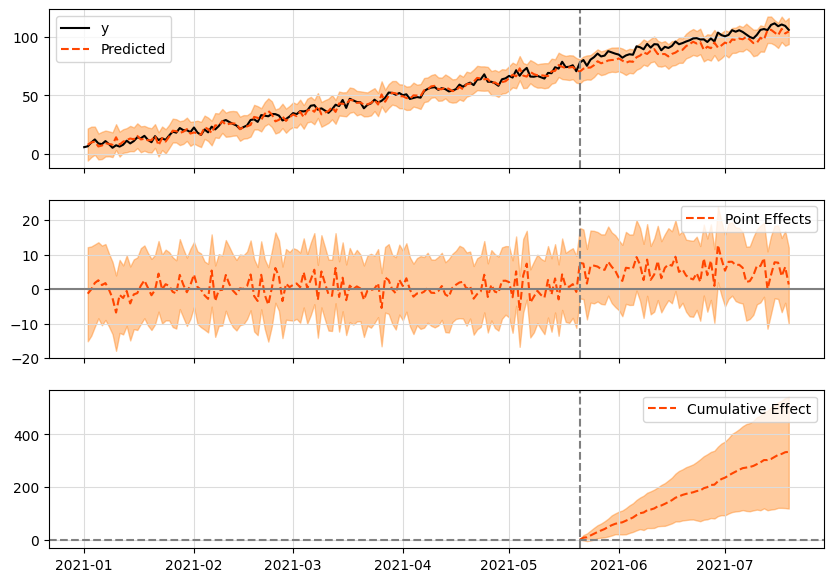

In [13]:
c.plot()

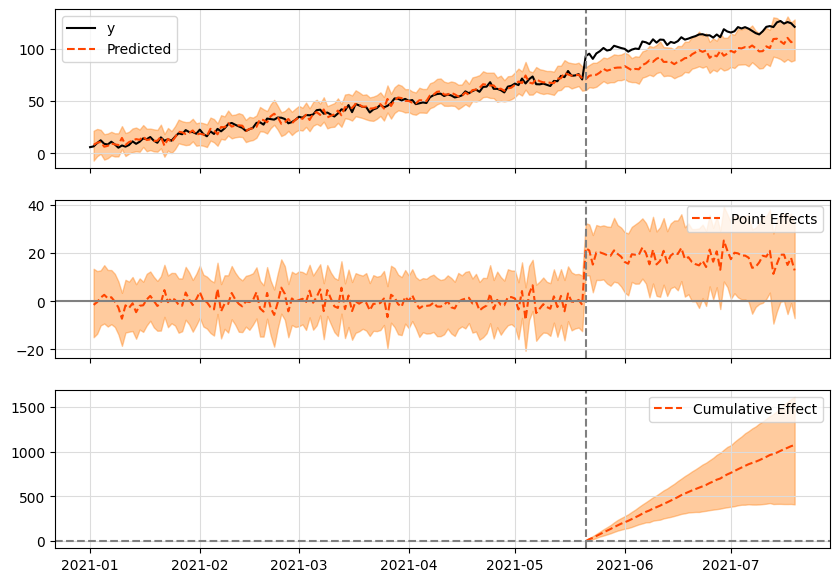

In [32]:
c.plot()

In [41]:
df = ts_data.rename(columns={"Value": "y", "Control_Value": "X"}).set_index("Time")
c = causalimpact.CausalImpact(df, pre_period=["20210101", "20210521"], post_period=["20210522", "20210719"])

/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/causalimpact/data.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():


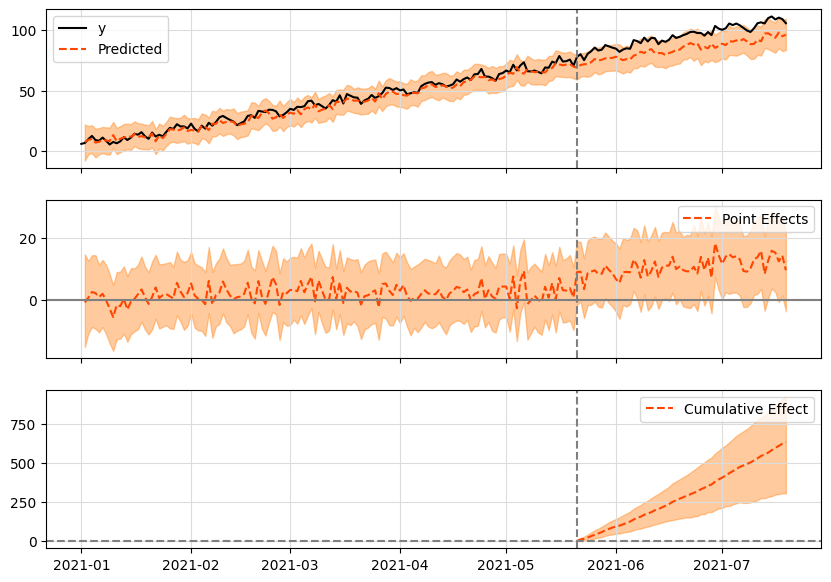

In [42]:
c.plot()

In [43]:
print(c.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    95.16              5614.36
Prediction (s.d.)         84.44 (2.81)       4982.12 (165.57)
95% CI                    [79.6, 90.6]       [4696.44, 5345.46]

Absolute effect (s.d.)    10.72 (2.81)       632.25 (165.57)
95% CI                    [4.56, 15.56]      [268.9, 917.92]

Relative effect (s.d.)    12.69% (3.32%)     12.69% (3.32%)
95% CI                    [5.4%, 18.42%]     [5.4%, 18.42%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
df = ts_data.rename(columns={"Value": "y", "Control_Value": "X"}).set_index("Time")
c = causalimpact.CausalImpact(df, pre_period=["20210101", "20210521"], post_period=["20210522", "20210719"], model_args={'fit_method': 'hmc'})

/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/causalimpact/data.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/Users/julienperichon/.pyenv/versions/3.11.6/envs/causal-impact-meetup/lib/python3.11/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [ ]:
c.plot()

In [ ]:
print(c.summary())